In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 데이터 불러오기

transform = transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_set = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# CPU/GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"{device} is available")

cuda:0 is available


In [4]:
# 모델링
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 6, 3, padding='same') # (입력 채널수, 출력 채널수, 3x3 필터크기, stride=1(default))
        self.pool1 = torch.nn.MaxPool2d(2, 2) # (2x2 필터크기, stride)
        self.conv2 = torch.nn.Conv2d(6, 16, 3, padding='same')
        self.pool2 = torch.nn.MaxPool2d(2, 2)
        self.fc1 = torch.nn.Linear(16*8*8, 120)
        self.fc2 = torch.nn.Linear(120, 10)
    
    def forward(self, x):
        x = torch.nn.functional.relu(self.conv1(x))
        x = self.pool1(x)
        x = torch.nn.functional.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(-1 ,16*8*8) # -1: 배치 사이즈
        x = torch.nn.functional.relu(self.fc1(x))
        x = self.fc2(x) # CrossEntropyLoss는 softmax계산까지 포함되어 있으므로 별도의 활성화 함수를 사용하지 않아도 된다.
        return x

# 모델 선언(GPU 사용)
net = Net().to(device)
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=10, bias=True)
)


In [5]:
# 손실 함수, 최적화 기법
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3, weight_decay=1e-7)

# 모델 학습
loss_ = []
n_batch = len(train_loader)

for epoch in range(20):
    
    running_loss = 0.0

    for i, data in enumerate(train_loader):

        images, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = net(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    loss_.append(running_loss/n_batch)
    print(f"[%d] loss: %.3f"%(epoch+1, running_loss/n_batch))

print(f"Finished Training")

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[1] loss: 1.500
[2] loss: 1.198
[3] loss: 1.069
[4] loss: 0.983
[5] loss: 0.919
[6] loss: 0.865
[7] loss: 0.826
[8] loss: 0.786
[9] loss: 0.746
[10] loss: 0.713
[11] loss: 0.680
[12] loss: 0.654
[13] loss: 0.619
[14] loss: 0.595
[15] loss: 0.570
[16] loss: 0.543
[17] loss: 0.520
[18] loss: 0.496
[19] loss: 0.475
[20] loss: 0.453
Finished Training


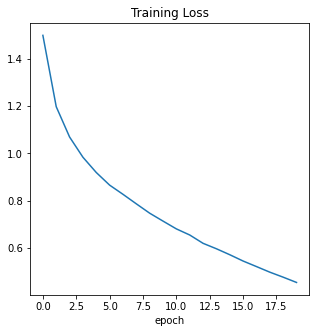

In [6]:
# 시각화
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(loss_)
ax.set_title('Training Loss')
ax.set_xlabel('epoch')
plt.show()

In [7]:
# 모델 저장히기
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

In [8]:
# 모델 불러오기
net = Net().to(device) # 모델 선언
net.load_state_dict(torch.load(PATH)) # 모델 파라미터 불러오기

<All keys matched successfully>

In [9]:
# 모델 정확도 구하기

correct = 0
total = 0 

with torch.no_grad():
    net.eval()
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        predicted = torch.max(outputs, axis=1)[1]
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy: {100*correct/total}")

Accuracy: 63.73
